深度地一次

In [15]:
import sys
print(sys.executable)


c:\Users\jerry\.conda\envs\RJ_text_1\python.exe


In [16]:
# 0) 套件
import os, sys, json, math, time, random
import numpy as np
import pandas as pd
from pathlib import Path

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt

import os, json, math, pandas as pd, numpy as np, warnings
warnings.filterwarnings("ignore")

import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, mean_squared_error, r2_score

import re
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold

print('Python:', sys.version)
print('PyTorch:', torch.__version__) # Python 跟 PyTorch 確認

print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU device name:", torch.cuda.get_device_name(0))#gpu 確認




Python: 3.10.13 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:15:57) [MSC v.1916 64 bit (AMD64)]
PyTorch: 2.5.1
CUDA available: True
GPU device name: NVIDIA GeForce RTX 4060 Laptop GPU


In [17]:
# 1) 載入資料
DATA_PATH = r"dataset.csv"  # dataset路徑
df = pd.read_csv(DATA_PATH)
print(df.shape)
df.head(3)

(4424, 35)


,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Nacionality,Mother's qualification,Father's qualification,Mother's occupation,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,8,5,2,1,1,1,13,10,6,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,6,1,11,1,1,1,1,3,4,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,5,1,1,1,22,27,10,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout


In [ ]:
# 2) 目標與特徵處理

TARGET_COL = 'Target'  # 已由探勘自動找到
assert TARGET_COL in df.columns, f"找不到目標欄位 {TARGET_COL}!"

y = df[TARGET_COL].astype('category')
X = df.drop(columns=[TARGET_COL])

# 自動推斷數值/類別欄位
num_cols = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
cat_cols = [c for c in X.columns if c not in num_cols]

print('數值欄位數:', len(num_cols))
print('類別欄位數:', len(cat_cols))

from sklearn.impute import SimpleImputer

#處理數值特徵（NaN）的資料，用中位數填(沒了)
numeric_transformer = Pipeline(steps=[
    #('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())#正規畫
])
#處理類別（字串）特徵
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),#缺值，眾數補上
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))#類別文字數值形式
])

preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ]
)

# 目標編碼：把類別轉成 0..K-1
class_names = list(y.cat.categories)
y_codes = y.cat.codes.values
num_classes = len(class_names)
print('Target名稱:', class_names)

TARGET_COL = 'Target'
class_counts = pd.read_csv('dataset.csv', usecols=[TARGET_COL])[TARGET_COL].value_counts()
print("\n各類別筆數：")
print(class_counts)
print("\n各類別比例：")
print((class_counts / class_counts.sum()).round(4))

數值欄位數: 34
類別欄位數: 0
Target名稱: ['Dropout', 'Enrolled', 'Graduate']

各類別筆數：
Target
Graduate    2209
Dropout     1421
Enrolled     794
Name: count, dtype: int64

各類別比例：
Target
Graduate    0.4993
Dropout     0.3212
Enrolled    0.1795
Name: count, dtype: float64


In [19]:
# 3) 切分資料 
from sklearn.model_selection import train_test_split

# 第一次：切出訓練資料 (70%)，剩下 30% 暫存
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_codes, test_size=0.3, random_state=42, stratify=y_codes
)

# 第二次：把暫存資料分成 驗證(15%) + 測試(15%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# 儲存每個集合大小
n_train, n_val, n_test = len(X_train), len(X_val), len(X_test)

print(f"訓練集：{n_train} 筆")
print(f"驗證集：{n_val} 筆")
print(f"測試集：{n_test} 筆")

訓練集：3096 筆
驗證集：664 筆
測試集：664 筆


In [20]:
# 4) 擬合前處理並轉成 numpy
X_train_np = preprocess.fit_transform(X_train)
X_val_np   = preprocess.transform(X_val)
X_test_np  = preprocess.transform(X_test)

input_dim = X_train_np.shape[1]
input_dim

34

In [ ]:
# 5) NumPy 資料打包成 PyTorch Dataset / Dataloader
class NumpyDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = NumpyDataset(X_train_np, y_train)
val_ds   = NumpyDataset(X_val_np, y_val)
test_ds  = NumpyDataset(X_test_np, y_test)

train_dl = DataLoader(train_ds, batch_size=128, shuffle=True)
val_dl   = DataLoader(val_ds, batch_size=256)
test_dl  = DataLoader(test_ds, batch_size=256)

In [22]:
# 6) 建立 MLP 模型 有ReLU
class MLP_Relu(nn.Module):
    def __init__(self, in_dim, num_classes):
        super().__init__()
        self.net = nn.Sequential(#是否本身有RELU
            nn.Linear(in_dim, 128),#輸入
            nn.BatchNorm1d(128),
            #nn.LeakyReLU(0.01),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, 64),#隱
            nn.BatchNorm1d(64),
            #nn.LeakyReLU(0.01),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(64, 32),#隱
            nn.BatchNorm1d(32),
            #nn.LeakyReLU(0.01),
            nn.ReLU(),
            nn.Dropout(0.3),


            nn.Linear(32, num_classes)#輸出
        )
    def forward(self, x):
        return self.net(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_Relu = MLP_Relu(input_dim, num_classes).to(device)
model_Relu

# 無激活函式版本
class MLP_Sigmoid(nn.Module):
    def __init__(self, in_dim, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 128),
            nn.BatchNorm1d(128),
            nn.Sigmoid(),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.Sigmoid(),
            nn.Dropout(0.3),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.Sigmoid(),
            nn.Dropout(0.3),

            nn.Linear(32, num_classes)
        )
    def forward(self, x):
        return self.net(x)

model_Sigmoid = MLP_Sigmoid(input_dim, num_classes).to(device)


In [23]:
# 7) 類別不平衡處理：class weights
# 依訓練資料的頻率反比計算權重
unique, counts = np.unique(y_train, return_counts=True)#取編號
freq = counts / counts.sum()#取編號次數
class_weights = torch.tensor(1.0 / (freq + 1e-8), dtype=torch.float32).to(device)#類別的比例 (frequency)。
print('class_weights:', class_weights)

criterion = nn.CrossEntropyLoss(weight=class_weights)#計算每個類別的反比權重-->損失函數


class_weights: tensor([3.1147, 5.5683, 2.0026], device='cuda:0')



===== 開始訓練 ReLU 版本，共 300 epochs =====
Epoch 001 | train_loss=1.0605 acc=0.5139 | val_loss=0.9694 acc=0.6867
Epoch 002 | train_loss=0.9227 acc=0.6395 | val_loss=0.8521 acc=0.7033
Epoch 003 | train_loss=0.8229 acc=0.7106 | val_loss=0.7997 acc=0.7139
Epoch 004 | train_loss=0.7875 acc=0.7122 | val_loss=0.7753 acc=0.7108
Epoch 005 | train_loss=0.7471 acc=0.7200 | val_loss=0.7666 acc=0.6988
Epoch 006 | train_loss=0.7160 acc=0.7245 | val_loss=0.7538 acc=0.6928
Epoch 007 | train_loss=0.7002 acc=0.7306 | val_loss=0.7476 acc=0.7003
Epoch 008 | train_loss=0.7021 acc=0.7348 | val_loss=0.7447 acc=0.7018
Epoch 009 | train_loss=0.6889 acc=0.7342 | val_loss=0.7345 acc=0.7154
Epoch 010 | train_loss=0.6892 acc=0.7416 | val_loss=0.7303 acc=0.7214
Epoch 011 | train_loss=0.6697 acc=0.7484 | val_loss=0.7258 acc=0.7169
Epoch 012 | train_loss=0.6596 acc=0.7494 | val_loss=0.7242 acc=0.7169
Epoch 013 | train_loss=0.6639 acc=0.7503 | val_loss=0.7222 acc=0.7139
Epoch 014 | train_loss=0.6552 acc=0.7481 | val_loss

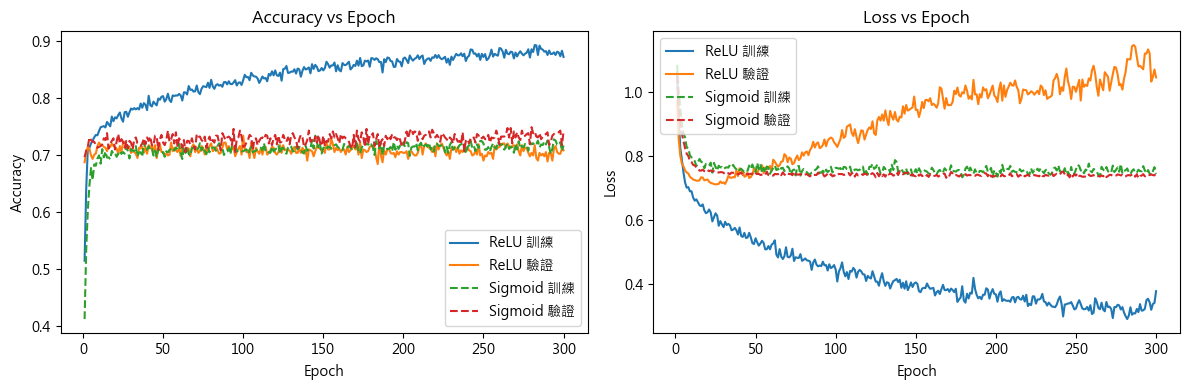


📊 === ReLU 版本 模型最終結果 ===
Train Loss: 0.3773
Val Loss:   1.0445
Train Acc:  0.8718
Val Acc:    0.7078

📊 === Sigmoid 版本 模型最終結果 ===
Train Loss: 0.7439
Val Loss:   0.7457
Train Acc:  0.7164
Val Acc:    0.7410


In [24]:
# ==== 1) Dataset & DataLoader ====
class NumpyDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

train_dl = DataLoader(NumpyDataset(X_train_np, y_train), batch_size=128, shuffle=True)
val_dl   = DataLoader(NumpyDataset(X_val_np, y_val),   batch_size=256)

# ==== 2) 驗證函式（把 model 與 criterion 當參數傳入）====
def evaluate(model, dataloader, criterion):
    model.eval()
    correct, total, losses = 0, 0, []
    with torch.no_grad():
        for xb, yb in dataloader:#(xb->輸入，yb標籤)
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)#模型預測的原始輸出
            loss = criterion(logits, yb)#計算這批資料的 loss
            losses.append(loss.item())#把 tensor 轉成普通數值->存起來，最後取平均
            preds = logits.argmax(dim=1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)
    return float(np.mean(losses)), correct / total

# ==== 3) 通用訓練函式（
def train_model(model, name, EPOCHS=30):
    model.to(device)
    #Adam 演算法（自動調整學習率） 學習率=lr weight_decay=L2正則化
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3,weight_decay=1e-3)
    criterion = nn.CrossEntropyLoss(weight=class_weights)

    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    print(f"\n===== 開始訓練 {name}，共 {EPOCHS} epochs =====")
    for epoch in range(1, EPOCHS + 1):
        model.train()
        total_loss, correct, total = 0.0, 0, 0#歸零

        for xb, yb in train_dl:#讀取每一個batch
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()#清空上一次梯度
            logits = model(xb)#前向傳遞
            loss = criterion(logits, yb)#算loss
            loss.backward()#反向傳遞，計算梯度
            optimizer.step()#根據梯度更新權重

            #計算當前 batch 的統計
            total_loss += loss.item()
            correct += (logits.argmax(1) == yb).sum().item()
            total += yb.size(0)
        #計算整體訓練集
        train_loss = total_loss / len(train_dl)
        train_acc  = correct / total
        #驗證模型
        val_loss, val_acc = evaluate(model, val_dl, criterion)

        # 每個 epoch 結束顯示結果
        print(
            f"Epoch {epoch:03d} | "
            f"train_loss={train_loss:.4f} acc={train_acc:.4f} | "
            f"val_loss={val_loss:.4f} acc={val_acc:.4f}"
        )

        # 紀錄曲線
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

    print(f"✅ {name} 訓練完成！")
    return model, history


# ==== 4) 訓練兩個版本並比較 ====
#EPOCHS = 50
EPOCHS = 300

model_relu  = MLP_Relu(input_dim, num_classes)
model_noact = MLP_Sigmoid(input_dim, num_classes)

model_relu,  hist_relu  = train_model(model_relu,  "ReLU 版本", EPOCHS)#tran Relu
model_noact, hist_noact = train_model(model_noact, "Sigmoid 版本", EPOCHS)#tran sigmoid

#model_relu  = train_model(model_relu,  "ReLU 版本", EPOCHS)
#model_noact = train_model(model_noact, "Sigmoid 版本", EPOCHS)

# 設定中文字體（Windows 建議用微軟正黑體）
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']
plt.rcParams['axes.unicode_minus'] = False

#畫圖
def plot_history(h1, h2, name1="ReLU", name2="Sigmoid"):
    epochs = range(1, len(h1["train_acc"]) + 1)
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    # Accuracy
    ax[0].plot(epochs, h1["train_acc"], label=f"{name1} 訓練")
    ax[0].plot(epochs, h1["val_acc"],   label=f"{name1} 驗證")
    ax[0].plot(epochs, h2["train_acc"], "--", label=f"{name2} 訓練")
    ax[0].plot(epochs, h2["val_acc"],   "--", label=f"{name2} 驗證")
    ax[0].set_title("Accuracy vs Epoch")
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("Accuracy")
    ax[0].legend()

    # Loss
    ax[1].plot(epochs, h1["train_loss"], label=f"{name1} 訓練")
    ax[1].plot(epochs, h1["val_loss"],   label=f"{name1} 驗證")
    ax[1].plot(epochs, h2["train_loss"], "--", label=f"{name2} 訓練")
    ax[1].plot(epochs, h2["val_loss"],   "--", label=f"{name2} 驗證")
    ax[1].set_title("Loss vs Epoch")
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("Loss")
    ax[1].legend()

    plt.tight_layout()
    plt.show()

plot_history(hist_relu, hist_noact)

def summarize_results(model, history, name):
    print(f"\n📊 === {name} 模型最終結果 ===")

    # 取出最後一個 epoch 的統計
    final_train_loss = history["train_loss"][-1]
    final_val_loss   = history["val_loss"][-1]
    final_train_acc  = history["train_acc"][-1]
    final_val_acc    = history["val_acc"][-1]

    print(f"Train Loss: {final_train_loss:.4f}")
    print(f"Val Loss:   {final_val_loss:.4f}")
    print(f"Train Acc:  {final_train_acc:.4f}")
    print(f"Val Acc:    {final_val_acc:.4f}")

    

# 輸出兩個模型的訓練結果與最後權重
summarize_results(model_relu,  hist_relu,  "ReLU 版本")
summarize_results(model_noact, hist_noact, "Sigmoid 版本")



In [25]:
# ==== XGBoost 訓練與結果 ====
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 1️⃣ 訓練 XGBoost 模型
xgb = XGBClassifier(
    n_estimators=200,       # 樹的數量
    max_depth=6,            # 每棵樹的最大深度
    learning_rate=0.05,     # 學習率
    subsample=0.8,          # 每次取樣比例
    colsample_bytree=0.8,   # 每棵樹取樣的特徵比例
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss'  # 多分類 loss
)

xgb.fit(X_train_np, y_train, eval_set=[(X_val_np, y_val)], verbose=False)

# 2️⃣ 驗證集與測試集預測
y_val_pred = xgb.predict(X_val_np)
y_test_pred = xgb.predict(X_test_np)

acc_val_xgb = accuracy_score(y_val, y_val_pred)
acc_test_xgb = accuracy_score(y_test, y_test_pred)

print(f"\n📊 === XGBoost 模型結果 ===")
print(f"Validation Accuracy: {acc_val_xgb:.4f}")
print(f"Test Accuracy:       {acc_test_xgb:.4f}")

print("\nValidation Classification Report:")
print(classification_report(y_val, y_val_pred, digits=4))

# print("Validation Confusion Matrix:")
# print(confusion_matrix(y_val, y_val_pred))

print("\nTest Classification Report:")
print(classification_report(y_test, y_test_pred, digits=4))

# print("Test Confusion Matrix:")
# print(confusion_matrix(y_test, y_test_pred))

# # 3️⃣ 加入 summary_df 表格
# rows = [
#     ("XGBoost (Val)", acc_val_xgb),
#     ("XGBoost (Test)", acc_test_xgb)
# ]

# if 'summary_df' in globals():
#     summary_df = pd.concat([summary_df, pd.DataFrame(rows, columns=["Pipeline", "Accuracy"])], ignore_index=True)
# else:
#     summary_df = pd.DataFrame(rows, columns=["Pipeline", "Accuracy"])

# print("\n=== Summary Table（含 XGBoost）===")
# display(summary_df)



📊 === XGBoost 模型結果 ===
Validation Accuracy: 0.7711
Test Accuracy:       0.8012

Validation Classification Report:
              precision    recall  f1-score   support

           0     0.8030    0.7465    0.7737       213
           1     0.5882    0.4202    0.4902       119
           2     0.7953    0.9127    0.8499       332

    accuracy                         0.7711       664
   macro avg     0.7288    0.6931    0.7046       664
weighted avg     0.7607    0.7711    0.7610       664


Test Classification Report:
              precision    recall  f1-score   support

           0     0.8601    0.7757    0.8157       214
           1     0.5900    0.4958    0.5388       119
           2     0.8275    0.9275    0.8746       331

    accuracy                         0.8012       664
   macro avg     0.7592    0.7330    0.7431       664
weighted avg     0.7954    0.8012    0.7955       664




===== 測試集評估：有 ReLU 版本 =====
              precision    recall  f1-score   support

     Dropout       0.83      0.75      0.79       214
    Enrolled       0.42      0.62      0.50       119
    Graduate       0.87      0.77      0.82       331

    accuracy                           0.74       664
   macro avg       0.71      0.71      0.70       664
weighted avg       0.78      0.74      0.75       664

Accuracy: 0.7380


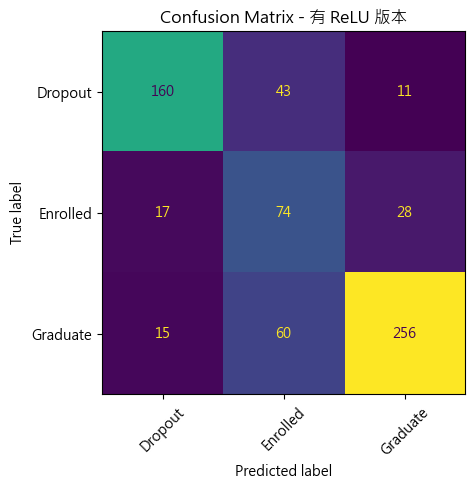


===== 測試集評估：無 ReLU 版本 =====
              precision    recall  f1-score   support

     Dropout       0.93      0.70      0.79       214
    Enrolled       0.47      0.59      0.52       119
    Graduate       0.83      0.89      0.86       331

    accuracy                           0.78       664
   macro avg       0.74      0.73      0.73       664
weighted avg       0.80      0.78      0.78       664

Accuracy: 0.7756


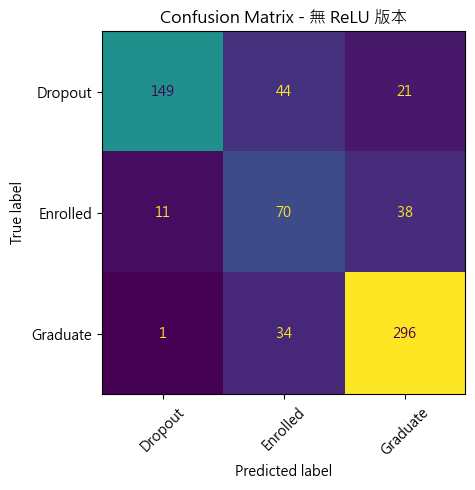


📊 測試集最終比較：
  有 ReLU 版本  Accuracy = 0.7380
  無 ReLU 版本  Accuracy = 0.7756


In [26]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']  # 微軟正黑體
plt.rcParams['axes.unicode_minus'] = False  # 正確顯示負號

#測試集評估：回傳 acc，印出 report，畫/存混淆矩陣
def evaluate_on_test(model, name="model", save_fig=True, fig_dir="outputs"):
    model.eval()
    Path(fig_dir).mkdir(parents=True, exist_ok=True)

    y_true, y_pred = [], []
    with torch.no_grad():
        for xb, yb in test_dl:
            xb = xb.to(device)
            yb = yb.to(device)
            logits = model(xb)
            preds = logits.argmax(1)

            y_pred.extend(preds.cpu().numpy().tolist())
            y_true.extend(yb.cpu().numpy().tolist())

    #  印出
    print(f"\n===== 測試集評估：{name} =====")
    print(classification_report(y_true, y_pred, target_names=[str(c) for c in class_names]))
    acc = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {acc:.4f}")

    # 混淆矩陣（顯示 + 可選擇存檔）
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[str(c) for c in class_names])
    fig, ax = plt.subplots(figsize=(6, 5))
    disp.plot(ax=ax, xticks_rotation=45, colorbar=False)
    plt.title(f"Confusion Matrix - {name}")
    plt.tight_layout()
    plt.show()

    return acc

#分別驗證
acc_relu  = evaluate_on_test(model_relu,  name="有 ReLU 版本")
acc_noact = evaluate_on_test(model_noact, name="無 ReLU 版本")

print(f"\n📊 測試集最終比較：\n  有 ReLU 版本  Accuracy = {acc_relu:.4f}\n  無 ReLU 版本  Accuracy = {acc_noact:.4f}")

In [27]:
# ==== MLP-ReLU + 驗證早停 (Early Stopping) ====
import torch
import torch.nn as nn
import numpy as np

# 你已有的：train_dl, val_dl, device, input_dim, num_classes, class_weights（可選）
# 若 evaluate(model, dataloader, criterion) 尚未宣告，這裡提供一個輕量版：
def _evaluate_default(model, dataloader, criterion, device):
    model.eval()
    correct, total, losses = 0, 0, []
    with torch.no_grad():
        for xb, yb in dataloader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)
            losses.append(loss.item())
            preds = logits.argmax(dim=1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)
    return float(np.mean(losses)), correct / total

# 若你已經有 evaluate()，改用你的函式：
_evaluate = evaluate if 'evaluate' in globals() else _evaluate_default

# MLP (ReLU) 結構：可依你原本習慣調整
class MLP_ReLU(nn.Module):
    def __init__(self, in_dim, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),

            nn.Linear(32, num_classes)
        )
    def forward(self, x):
        return self.net(x)

def train_with_early_stopping(
    EPOCHS=300,
    patience=20,
    min_delta=1e-4,            # 最小改善幅度（相對前次最佳 val_loss）
    lr=1e-3,
    weight_decay=1e-3,         # L2 正則（可視情況調整）
    monitor="val_loss"         # 可選 "val_loss" 或 "val_acc"
):
    model = MLP_ReLU(input_dim, num_classes).to(device)

    # 損失：若你有 class_weights 就用，否則為 None
    cw = class_weights.to(device) if 'class_weights' in globals() and class_weights is not None else None
    criterion = nn.CrossEntropyLoss(weight=cw)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    # 驗證集停滯時自動降 LR
    if monitor == "val_loss":
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=max(patience//4, 3), verbose=True)
    else:
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=max(patience//4, 3), verbose=True)

    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    best_score = None
    best_state = None
    best_epoch = -1
    no_improve = 0

    print(f"\n===== 開始訓練 MLP-ReLU（Early Stopping）共 {EPOCHS} epochs | 監控 {monitor}，patience={patience} =====")
    for epoch in range(1, EPOCHS + 1):
        # ---- Train ----
        model.train()
        total_loss, correct, total = 0.0, 0, 0
        for xb, yb in train_dl:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            correct += (logits.argmax(1) == yb).sum().item()
            total += yb.size(0)

        train_loss = total_loss / len(train_dl)
        train_acc  = correct / total

        # ---- Val ----
        val_loss, val_acc = _evaluate(model, val_dl, criterion)

        # 紀錄
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        # 監控分數
        score = -val_loss if monitor == "val_loss" else val_acc

        # 更新 LR 調整器
        scheduler.step(val_loss if monitor == "val_loss" else val_acc)

        # 是否改善
        improved = False
        if best_score is None:
            improved = True
        else:
            if monitor == "val_loss":
                improved = (val_loss < (-best_score - min_delta))  # best_score 存的是 -best_val_loss
            else:
                improved = (val_acc > (best_score + min_delta))

        if improved:
            best_score  = -val_loss if monitor == "val_loss" else val_acc
            best_state  = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            best_epoch  = epoch
            no_improve  = 0
        else:
            no_improve += 1

        print(f"Epoch {epoch:03d} | train_loss={train_loss:.4f} acc={train_acc:.4f} | val_loss={val_loss:.4f} acc={val_acc:.4f} | no_improve={no_improve}")

        if no_improve >= patience:
            print(f"⏹ 早停：連續 {patience} 個 epoch 無顯著改善（監控 {monitor}）。")
            break

    # 還原最佳權重
    if best_state is not None:
        model.load_state_dict({k: v.to(device) for k, v in best_state.items()})
        print(f"✅ 已還原最佳權重（最佳 epoch = {best_epoch}）")
    else:
        print("⚠️ 未記錄到最佳權重，使用最後一輪參數。")

    return model, history, best_epoch

# ===== 執行訓練（你可依需要調整參數）=====
EPOCHS   = 300
PATIENCE = 30
model_relu_es, hist_relu_es, best_epoch = train_with_early_stopping(
    EPOCHS=EPOCHS, patience=PATIENCE, min_delta=1e-4, lr=1e-3, weight_decay=1e-3, monitor="val_loss"
)

print(f"\n最佳 epoch（val_loss 監控）：{best_epoch}")
# ==== 早停後：用最佳權重評估 Val / Test ====
# 和訓練時一致的 criterion（若你有 class_weights 就會套用）
cw = class_weights.to(device) if 'class_weights' in globals() and class_weights is not None else None
criterion = nn.CrossEntropyLoss(weight=cw)

# 使用你前面同一個 evaluate（或本格的 _evaluate_default）
val_loss,  val_acc  = _evaluate(model_relu_es, val_dl,  criterion)
test_loss, test_acc = _evaluate(model_relu_es, test_dl, criterion)

print("\n===== 早停後最終評估（以最佳權重）=====")
print(f"Validation: loss={val_loss:.4f}  acc={val_acc:.4f}")
print(f"Test:       loss={test_loss:.4f}  acc={test_acc:.4f}")


===== 開始訓練 MLP-ReLU（Early Stopping）共 300 epochs | 監控 val_loss，patience=30 =====
Epoch 001 | train_loss=1.0690 acc=0.4034 | val_loss=0.9954 acc=0.5497 | no_improve=0
Epoch 002 | train_loss=0.9111 acc=0.6040 | val_loss=0.8771 acc=0.6642 | no_improve=0
Epoch 003 | train_loss=0.8294 acc=0.6644 | val_loss=0.8216 acc=0.6898 | no_improve=0
Epoch 004 | train_loss=0.7940 acc=0.6964 | val_loss=0.7858 acc=0.6762 | no_improve=0
Epoch 005 | train_loss=0.7506 acc=0.7016 | val_loss=0.7700 acc=0.6807 | no_improve=0
Epoch 006 | train_loss=0.7213 acc=0.7171 | val_loss=0.7499 acc=0.6958 | no_improve=0
Epoch 007 | train_loss=0.7214 acc=0.7125 | val_loss=0.7459 acc=0.7048 | no_improve=0
Epoch 008 | train_loss=0.6984 acc=0.7387 | val_loss=0.7347 acc=0.7154 | no_improve=0
Epoch 009 | train_loss=0.6942 acc=0.7193 | val_loss=0.7417 acc=0.7003 | no_improve=1
Epoch 010 | train_loss=0.6954 acc=0.7297 | val_loss=0.7329 acc=0.7108 | no_improve=0
Epoch 011 | train_loss=0.6818 acc=0.7374 | val_loss=0.7237 acc=0.7093


===== MLP (ReLU) 測試集報告 =====
              precision    recall  f1-score   support

     Dropout     0.8333    0.7477    0.7882       214
    Enrolled     0.4181    0.6218    0.5000       119
    Graduate     0.8678    0.7734    0.8179       331

    accuracy                         0.7380       664
   macro avg     0.7064    0.7143    0.7020       664
weighted avg     0.7761    0.7380    0.7513       664



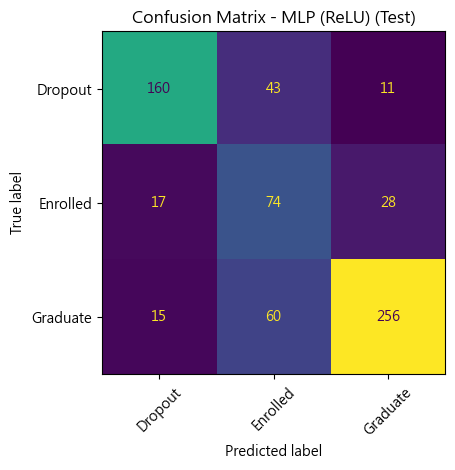


===== MLP (Sigmoid) 測試集報告 =====
              precision    recall  f1-score   support

     Dropout     0.9255    0.6963    0.7947       214
    Enrolled     0.4730    0.5882    0.5243       119
    Graduate     0.8338    0.8943    0.8630       331

    accuracy                         0.7756       664
   macro avg     0.7441    0.7263    0.7273       664
weighted avg     0.7987    0.7756    0.7803       664



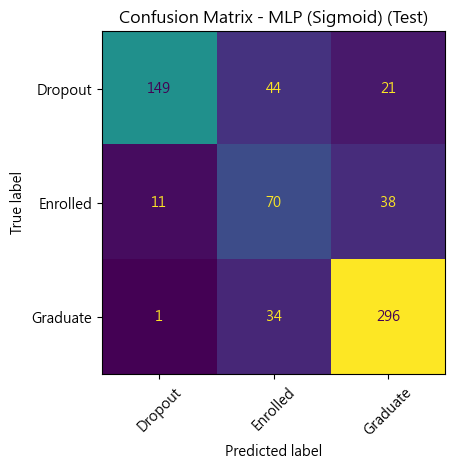


===== XGBoost 測試集報告 =====
              precision    recall  f1-score   support

     Dropout     0.8601    0.7757    0.8157       214
    Enrolled     0.5900    0.4958    0.5388       119
    Graduate     0.8275    0.9275    0.8746       331

    accuracy                         0.8012       664
   macro avg     0.7592    0.7330    0.7431       664
weighted avg     0.7954    0.8012    0.7955       664



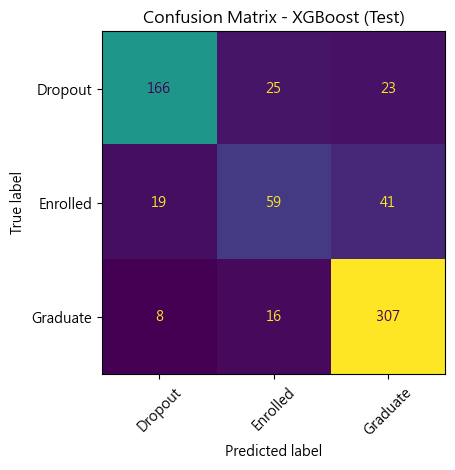


📊 測試集最終總表：


,Model,Accuracy,Precision,Recall,F1-score
0,MLP (ReLU),0.737952,0.706403,0.714309,0.702023
1,MLP (Sigmoid),0.775602,0.744081,0.726252,0.727328
2,XGBoost,0.801205,0.759199,0.732997,0.743060


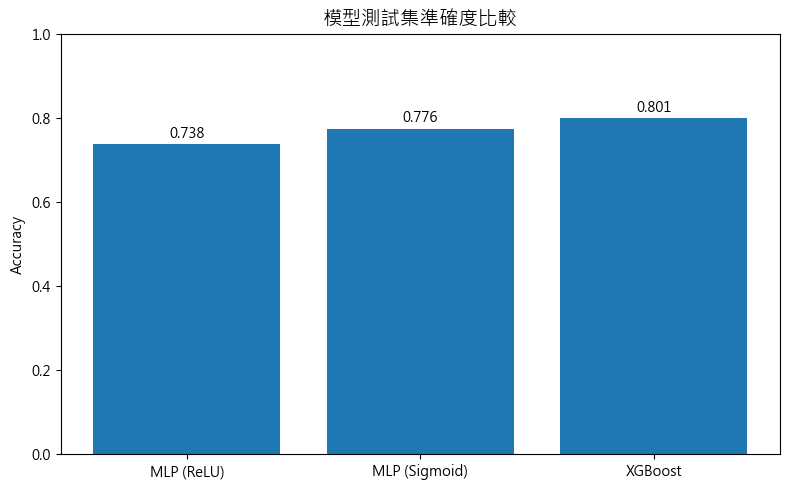

In [28]:
# ==== 三種方法（MLP-ReLU / MLP-Sigmoid / XGBoost）測試集整合評估 ====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)

plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']
plt.rcParams['axes.unicode_minus'] = False

# --- 統一計算指標 ---
def compute_metrics(y_true, y_pred):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, average="macro", zero_division=0),
        "Recall": recall_score(y_true, y_pred, average="macro", zero_division=0),
        "F1-score": f1_score(y_true, y_pred, average="macro", zero_division=0)
    }

# --- Torch 模型（MLP）---
def eval_torch(model, dataloader, name, class_names):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for xb, yb in dataloader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            preds = logits.argmax(1)
            y_true.extend(yb.cpu().numpy().tolist())
            y_pred.extend(preds.cpu().numpy().tolist())

    print(f"\n===== {name} 測試集報告 =====")
    print(classification_report(y_true, y_pred, target_names=[str(c) for c in class_names], digits=4))
    cm = confusion_matrix(y_true, y_pred)
    ConfusionMatrixDisplay(cm, display_labels=[str(c) for c in class_names]).plot(
        xticks_rotation=45, colorbar=False
    )
    plt.title(f"Confusion Matrix - {name} (Test)")
    plt.tight_layout()
    plt.show()

    return compute_metrics(y_true, y_pred)

# --- Sklearn / XGBoost 模型 ---
def eval_sklearn(model, X, y, name, class_names):
    y_pred = model.predict(X)
    print(f"\n===== {name} 測試集報告 =====")
    print(classification_report(y, y_pred, target_names=[str(c) for c in class_names], digits=4))
    cm = confusion_matrix(y, y_pred)
    ConfusionMatrixDisplay(cm, display_labels=[str(c) for c in class_names]).plot(
        xticks_rotation=45, colorbar=False
    )
    plt.title(f"Confusion Matrix - {name} (Test)")
    plt.tight_layout()
    plt.show()

    return compute_metrics(y, y_pred)

# --- 開始評估 ---
results = []

if 'model_relu' in globals() and 'test_dl' in globals():
    results.append({"Model": "MLP (ReLU)", **eval_torch(model_relu, test_dl, "MLP (ReLU)", class_names)})

if 'model_noact' in globals() and 'test_dl' in globals():
    results.append({"Model": "MLP (Sigmoid)", **eval_torch(model_noact, test_dl, "MLP (Sigmoid)", class_names)})

if 'xgb' in globals() and 'X_test_np' in globals() and 'y_test' in globals():
    results.append({"Model": "XGBoost", **eval_sklearn(xgb, X_test_np, y_test, "XGBoost", class_names)})

# --- 整合表格與繪圖 ---
if len(results) == 0:
    print("⚠️ 沒有找到可用模型或測試資料。")
else:
    test_summary = pd.DataFrame(results)
    print("\n📊 測試集最終總表：")
    display(test_summary)

    # 繪製圖表
    plt.figure(figsize=(8,5))
    bars = plt.bar(test_summary["Model"], test_summary["Accuracy"])
    plt.title("模型測試集準確度比較", fontsize=14)
    plt.ylabel("Accuracy")
    for b in bars:
        v = b.get_height()
        plt.text(b.get_x()+b.get_width()/2, v+0.005, f"{v:.3f}", ha='center', va='bottom')
    plt.ylim(0, 1.0)
    plt.tight_layout()
    plt.show()


In [29]:
# 10) 儲存模型與前處理器
SAVE_DIR = Path('./outputs'); SAVE_DIR.mkdir(exist_ok=True)

torch.save(model_relu.state_dict(), SAVE_DIR/'mlp_student_dropout_relu.pt')
#model_noact
torch.save(model_noact.state_dict(), SAVE_DIR/'mlp_student_dropout_noact.pt')

import joblib
joblib.dump(preprocess, SAVE_DIR/'preprocess.joblib')
with open(SAVE_DIR/'meta.json','w',encoding='utf-8') as f:
    json.dump({'class_names': [str(c) for c in class_names], 'input_dim': int(input_dim)}, f, ensure_ascii=False, indent=2)

print('Saved to', SAVE_DIR.resolve())

Saved to C:\Users\jerry\OneDrive\桌面\深度\第一次demo\outputs
